### Connect to Drive

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')

In [2]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [4]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = '../input/homework1/training_data_final'

In [5]:
# Random seed for reproducibility
seed = 1337

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

In [7]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(
        validation_split=0.15, 
        rescale=1/255.,
)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="validation",
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False,
                                               seed=seed)

Found 3015 images belonging to 8 classes.
Found 527 images belonging to 8 classes.


In [8]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [9]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]
    
    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    
    image = image*255
    
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (64, 96, 96, 3)
Target shape: (64, 8)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Species1


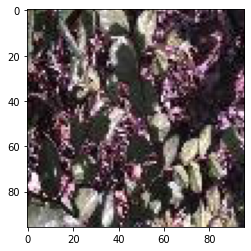

In [10]:
# Get a sample from dataset and show info
_ = get_next_batch(valid_gen)

### Models metadata

In [11]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

2022-11-16 00:35:14.572533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 00:35:14.745185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 00:35:14.746177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 00:35:14.747857: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

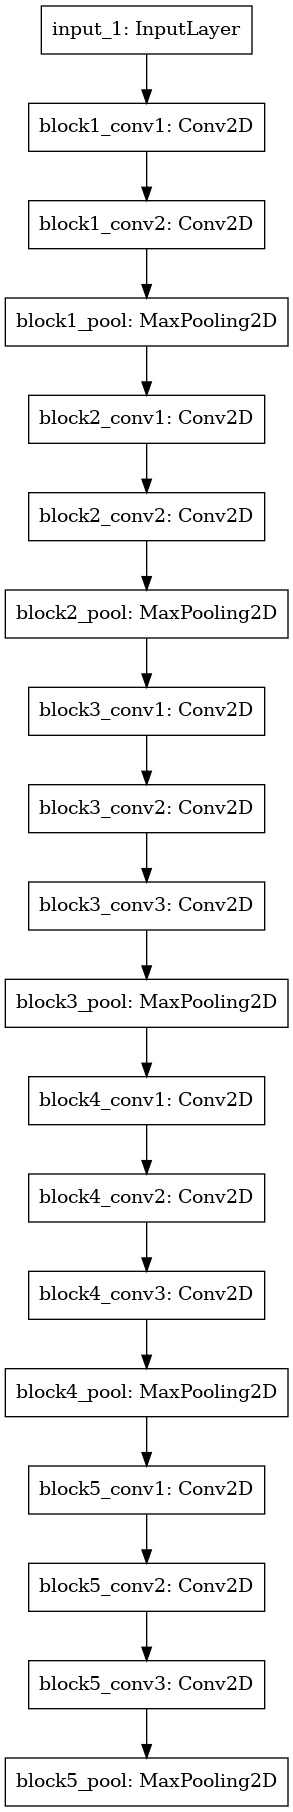

In [12]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
# Use the supernet as feature extractor
supernet.trainable = False

supernet.summary()
tfk.utils.plot_model(supernet)

In [18]:
inputs = tfk.Input(shape=input_shape)
x = tfkl.Conv2D(
    filters = 32,
    kernel_size = (3,3),
    activation = 'relu',
    name = 'conv1'
)(inputs)
x = tfkl.MaxPooling2D(name='pool1')(x)

x = tfkl.Conv2D(
    filters = 64,
    kernel_size = (3,3),
    activation = 'relu',
    name = 'conv2'
)(x)
x = tfkl.MaxPooling2D(name='pool2')(x)

x = tfkl.Conv2D(
    filters = 128,
    kernel_size = (3,3),
    activation = 'relu',
    name = 'conv3'
)(x)
x = tfkl.GlobalAveragePooling2D(name='gpooling')(x)


x = tfkl.Dropout(.3, seed=seed, name='dropout1')(x)
x = tfkl.Dense(
    64, 
    activation='relu', 
    name='classifier'
)(x)
x = tfkl.Dropout(.3, seed=seed, name='dropout2')(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 94, 94, 32)        896       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 20, 20, 128)       73856     
_________________________________________________________________
gpooling (GlobalAveragePooli (None, 128)               0     

In [19]:
# Train the model
history = tl_model.fit(
    x = train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
).history

Epoch 1/200
48/48 [==============================] - 5s 90ms/step - loss: 2.0226 - accuracy: 0.1867 - val_loss: 1.9302 - val_accuracy: 0.2372
Epoch 2/200
48/48 [==============================] - 4s 92ms/step - loss: 1.8817 - accuracy: 0.2756 - val_loss: 1.7805 - val_accuracy: 0.2922
Epoch 3/200
48/48 [==============================] - 4s 84ms/step - loss: 1.8032 - accuracy: 0.2813 - val_loss: 1.7812 - val_accuracy: 0.3036
Epoch 4/200
48/48 [==============================] - 5s 100ms/step - loss: 1.7460 - accuracy: 0.3101 - val_loss: 1.7080 - val_accuracy: 0.3112
Epoch 5/200
48/48 [==============================] - 4s 84ms/step - loss: 1.7063 - accuracy: 0.3267 - val_loss: 1.6635 - val_accuracy: 0.3472
Epoch 6/200
48/48 [==============================] - 4s 85ms/step - loss: 1.6352 - accuracy: 0.3701 - val_loss: 1.6096 - val_accuracy: 0.3757
Epoch 7/200
48/48 [==============================] - 4s 85ms/step - loss: 1.6409 - accuracy: 0.3625 - val_loss: 1.6787 - val_accuracy: 0.3245
Epoch

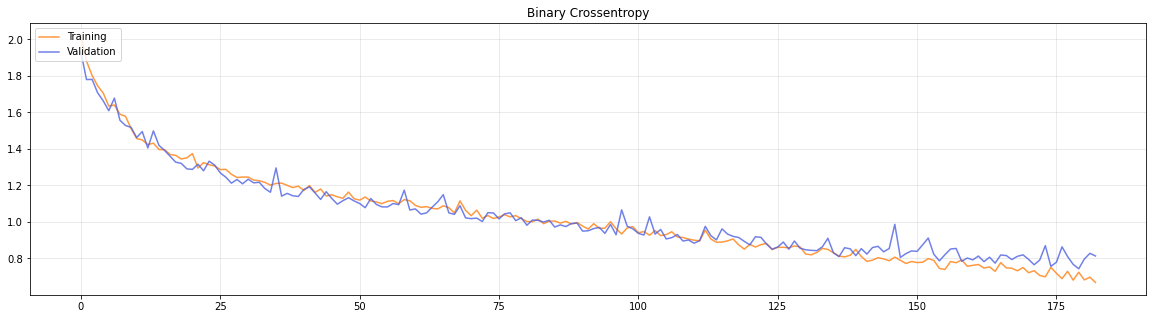

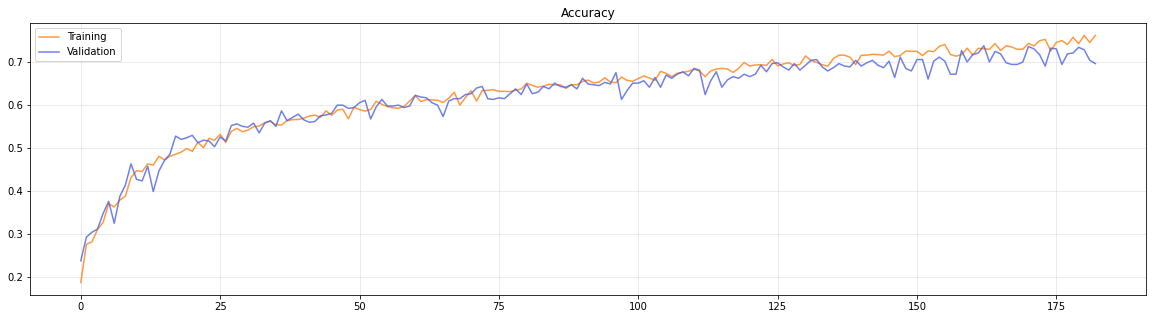

In [20]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [21]:
tl_model.save('ANN_Homework1_Model')

2022-11-16 01:10:26.842060: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [23]:
import shutil
shutil.make_archive("ANN_Homework1_Model", 'zip', '/kaggle/working/ANN_Homework1_Model')

'/kaggle/working/output.zip'